In [1]:
import os
import cv2
import numpy as np

def convert_mask_to_yolo_format(mask_path, label_path, class_id, image_size):
    # Load the mask image (grayscale)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    height, width = mask.shape[:2]

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Prepare the label file
    with open(label_path, 'w') as label_file:
        for contour in contours:
            # Get bounding box for each contour
            x, y, w, h = cv2.boundingRect(contour)

            # YOLO format requires x_center, y_center, width, height normalized by image size
            x_center = (x + w / 2) / width
            y_center = (y + h / 2) / height
            w_norm = w / width
            h_norm = h / height

            # Write the class ID and bounding box in YOLO format
            label_file.write(f"{class_id} {x_center} {y_center} {w_norm} {h_norm}\n")

def process_dataset(image_dir, mask_dir, label_dir, class_id=0):
    # Ensure label directory exists
    os.makedirs(label_dir, exist_ok=True)

    for filename in os.listdir(mask_dir):
        if filename.endswith(".png") or filename.endswith(".jpg"):
            # Define paths for mask and label
            mask_path = os.path.join(mask_dir, filename)
            label_path = os.path.join(label_dir, os.path.splitext(filename)[0] + ".txt")

            # Convert mask to YOLO format
            convert_mask_to_yolo_format(mask_path, label_path, class_id, image_size=(640, 640))

if __name__ == "__main__":
    # Directories containing images, masks, and where to save labels
    image_dir = r"C:\Project\Suburu\Jan\09_01_2024\ClipTower\Images"  # Not used here but typically necessary
    mask_dir = r"C:\Project\Suburu\Jan\09_01_2024\ClipTower\masked_images"
    label_dir = r"C:\Project\Suburu\Jan\09_01_2024\ClipTower\Labels"

    # Process the dataset
    process_dataset(image_dir, mask_dir, label_dir, class_id=0)


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt


In [4]:
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def load_images_and_masks(image_folder, mask_folder, image_size=(256, 256)):
    images = []
    masks = []
    
    for image_filename in os.listdir(image_folder):
        # Load the image
        image_path = os.path.join(image_folder, image_filename)
        image = load_img(image_path, target_size=image_size)
        image = img_to_array(image) / 255.0
        images.append(image)

        # Load the corresponding mask
        mask_filename = image_filename.replace(".png", "_mask.png")  # Adjust for mask filename
        mask_path = os.path.join(mask_folder, mask_filename)
        
        if os.path.exists(mask_path):
            mask = load_img(mask_path, target_size=image_size, color_mode="grayscale")
            mask = img_to_array(mask) / 255.0
            masks.append(mask)
        else:
            print(f"Mask not found for {image_filename}")

    return np.array(images), np.array(masks)

# Specify the directories
image_folder = r"C:\Project\Suburu\Jan\09_01_2024\ClipTower\XPL\images"
mask_folder =r"C:\Project\Suburu\Jan\09_01_2024\ClipTower\XPL\masked_images"

# Load the images and masks
images, masks = load_images_and_masks(image_folder, mask_folder)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [5]:
import tensorflow as tf

def unet_model(input_size=(256, 256, 3), num_classes=4):
    inputs = tf.keras.layers.Input(input_size)
    
    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
    
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
    
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
    
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)
    
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(p4)
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation='relu', padding='same')(c5)
    
    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = tf.keras.layers.concatenate([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(u6)
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='same')(c6)
    
    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = tf.keras.layers.concatenate([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(u7)
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='same')(c7)
    
    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = tf.keras.layers.concatenate([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(u8)
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')(c8)
    
    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = tf.keras.layers.concatenate([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(u9)
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(c9)
    
    outputs = tf.keras.layers.Conv2D(num_classes, (1, 1), activation='softmax')(c9)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model

# Initialize and compile the model
model = unet_model(input_size=(256, 256, 3), num_classes=2)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [6]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256, 256, 3], include_top=False)

In [7]:
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=4, epochs=30)

Epoch 1/30
8/8 [==============================] - 76s 9s/step - loss: 0.5832 - accuracy: 0.7881 - val_loss: 0.4524 - val_accuracy: 0.8762
Epoch 2/30
8/8 [==============================] - 72s 9s/step - loss: 0.4136 - accuracy: 0.8821 - val_loss: 0.4241 - val_accuracy: 0.8762
Epoch 3/30
8/8 [==============================] - 72s 9s/step - loss: 0.4053 - accuracy: 0.8821 - val_loss: 0.3984 - val_accuracy: 0.8762
Epoch 4/30
8/8 [==============================] - 72s 9s/step - loss: 0.3660 - accuracy: 0.8821 - val_loss: 0.3774 - val_accuracy: 0.8762
Epoch 5/30
8/8 [==============================] - 72s 9s/step - loss: 0.3436 - accuracy: 0.8821 - val_loss: 0.3621 - val_accuracy: 0.8762
Epoch 6/30
8/8 [==============================] - 73s 9s/step - loss: 0.3373 - accuracy: 0.8821 - val_loss: 0.3594 - val_accuracy: 0.8762
Epoch 7/30
8/8 [==============================] - 77s 10s/step - loss: 0.3318 - accuracy: 0.8821 - val_loss: 0.3460 - val_accuracy: 0.8762
Epoch 8/30
8/8 [=================

In [8]:
val_loss, val_acc = model.evaluate(X_val, y_val)
print(f'Validation Loss: {val_loss}, Validation Accuracy: {val_acc}')

1/1 [==============================] - 4s 4s/step - loss: 0.1994 - accuracy: 0.9326
Validation Loss: 0.1993674486875534, Validation Accuracy: 0.9325580596923828


In [9]:
import matplotlib.pyplot as plt

def plot_sample(image, true_mask, pred_mask):
    """
    Plots the image, true mask, and predicted mask side by side.

    Parameters:
        image (numpy array): The input image.
        true_mask (numpy array): The ground truth mask.
        pred_mask (numpy array): The predicted mask by the model.
    """
    plt.figure(figsize=(12, 8))

    # Original Image
    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title('Original Image')
    plt.axis('off')

    # True Mask
    plt.subplot(1, 3, 2)
    plt.imshow(true_mask, cmap='gray')
    plt.title('True Mask')
    plt.axis('off')

    # Predicted Mask
    plt.subplot(1, 3, 3)
    plt.imshow(pred_mask, cmap='gray')
    plt.title('Predicted Mask')
    plt.axis('off')

    plt.show()


1/1 [==============================] - 1s 853ms/step


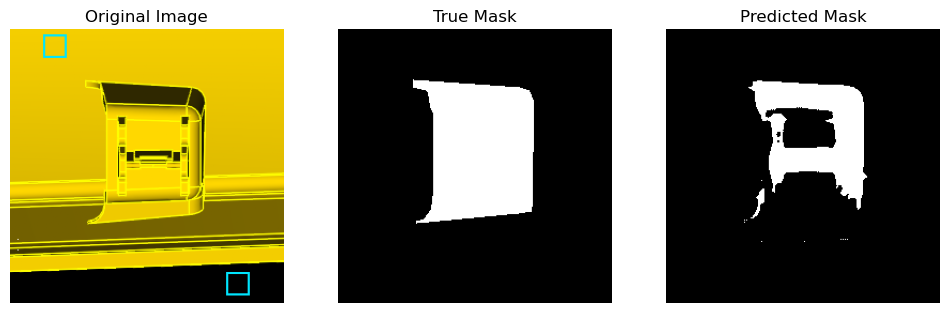

1/1 [==============================] - 1s 535ms/step


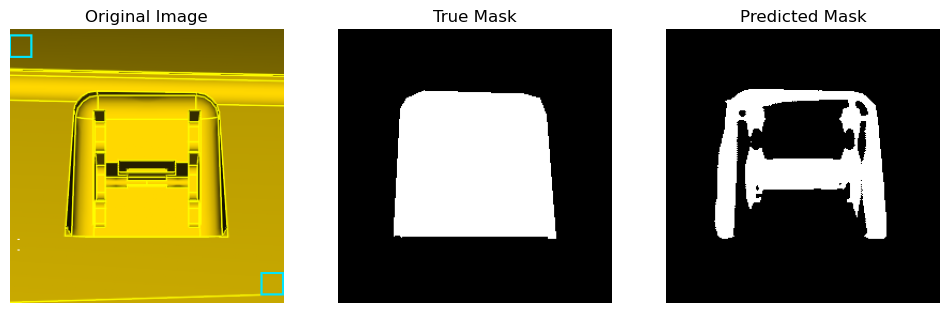

1/1 [==============================] - 1s 528ms/step


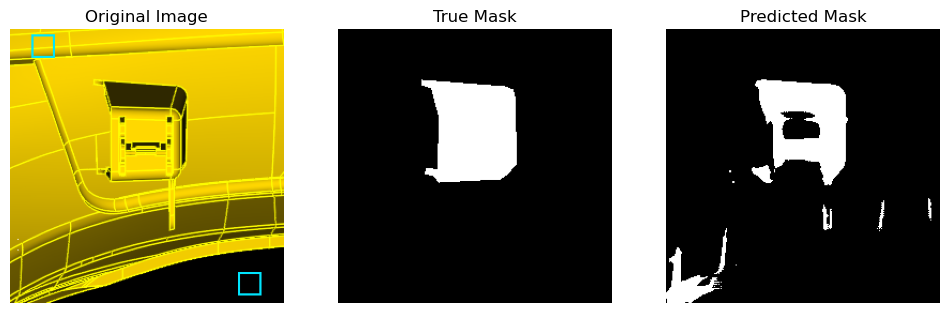

In [10]:
# Select indices for images to evaluate
indices = [1, 3, 2]  # Change these indices as needed

for idx in indices:
    # Make prediction
    y_pred = model.predict(X_val[idx:idx+1])

    # Post-process the prediction to match the mask format
    pred_mask = tf.argmax(y_pred[0], axis=-1)  # Convert logits to class labels
    pred_mask = pred_mask[..., tf.newaxis]      # Add channel dimension if needed

    # Plot the image, ground truth mask, and predicted mask
    plot_sample(X_val[idx], y_val[idx], pred_mask)